# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [13]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change).
    They are parallel and located at opposite ends of the frame.
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.

In [3]:
l = 0.5  # length in meters
r = 0.125  # radius in meters

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

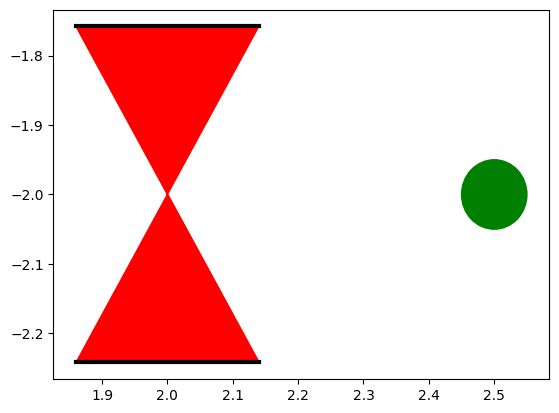

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def draw_scooter(x, y, theta):

    x_C=x
    y_C=y
    # Calcul de la hauteur du triangle
    h = np.sqrt((l/2)**2 + r**2)

    # Calcul des angles pour les sommets du triangle
    gamma = theta - np.pi / 6
    gamma1 = theta + np.pi / 6

    # Calcul des coordonnées des sommets du triangle
    x1 = x + h * np.sin(gamma)
    y1 = y - h * np.cos(gamma)

    x2 = x + h * np.sin(gamma1)
    y2 = y - h * np.cos(gamma1)

    x3 = x - h * np.sin(gamma)
    y3 = y + h * np.cos(gamma)

    x4 = x - h * np.sin(gamma1)
    y4 = y + h * np.cos(gamma1)

    # Coordonnées des sommets du triangle
    x_L = [x2, x1, x3, x4]  # Coordonnées x des sommets
    y_L = [y2, y1, y3, y4]  # Coordonnées y des sommets

    x= [x,x,x,x]
    y=[y,y,y,y]
    # Tracer les lignes du triangle
    plt.plot(x + [x_L[0]], y + [y_L[0]] ,color='red')

    # Remplir le triangle pour le rendre plein
    plt.fill(x_L, y_L, color='red')


    # Tracer la ligne entre les deux points avec une épaisseur de trait de 3
    plt.plot([x1, x2], [y1, y2], color='black', linewidth=3)
    plt.plot([x3, x4], [y3, y4], color='black', linewidth=3)

    # Calcul du centre du cercle circonscrit
    x_C = x_C + l * np.cos(theta)
    y_C = y_C + l * np.sin(theta)

    # Créer un cercle plein
    circle = plt.Circle((x_C, y_C), 0.05 , color='green', fill=True)

    # Ajouter le cercle à l'axe actuel
    plt.gca().add_patch(circle)




# Exemple d'utilisation :
vertex_x = 2
vertex_y = -2
theta = 0
draw_scooter(vertex_x, vertex_y, theta)


🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [6]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

<function matplotlib.pyplot.show(close=None, block=None)>

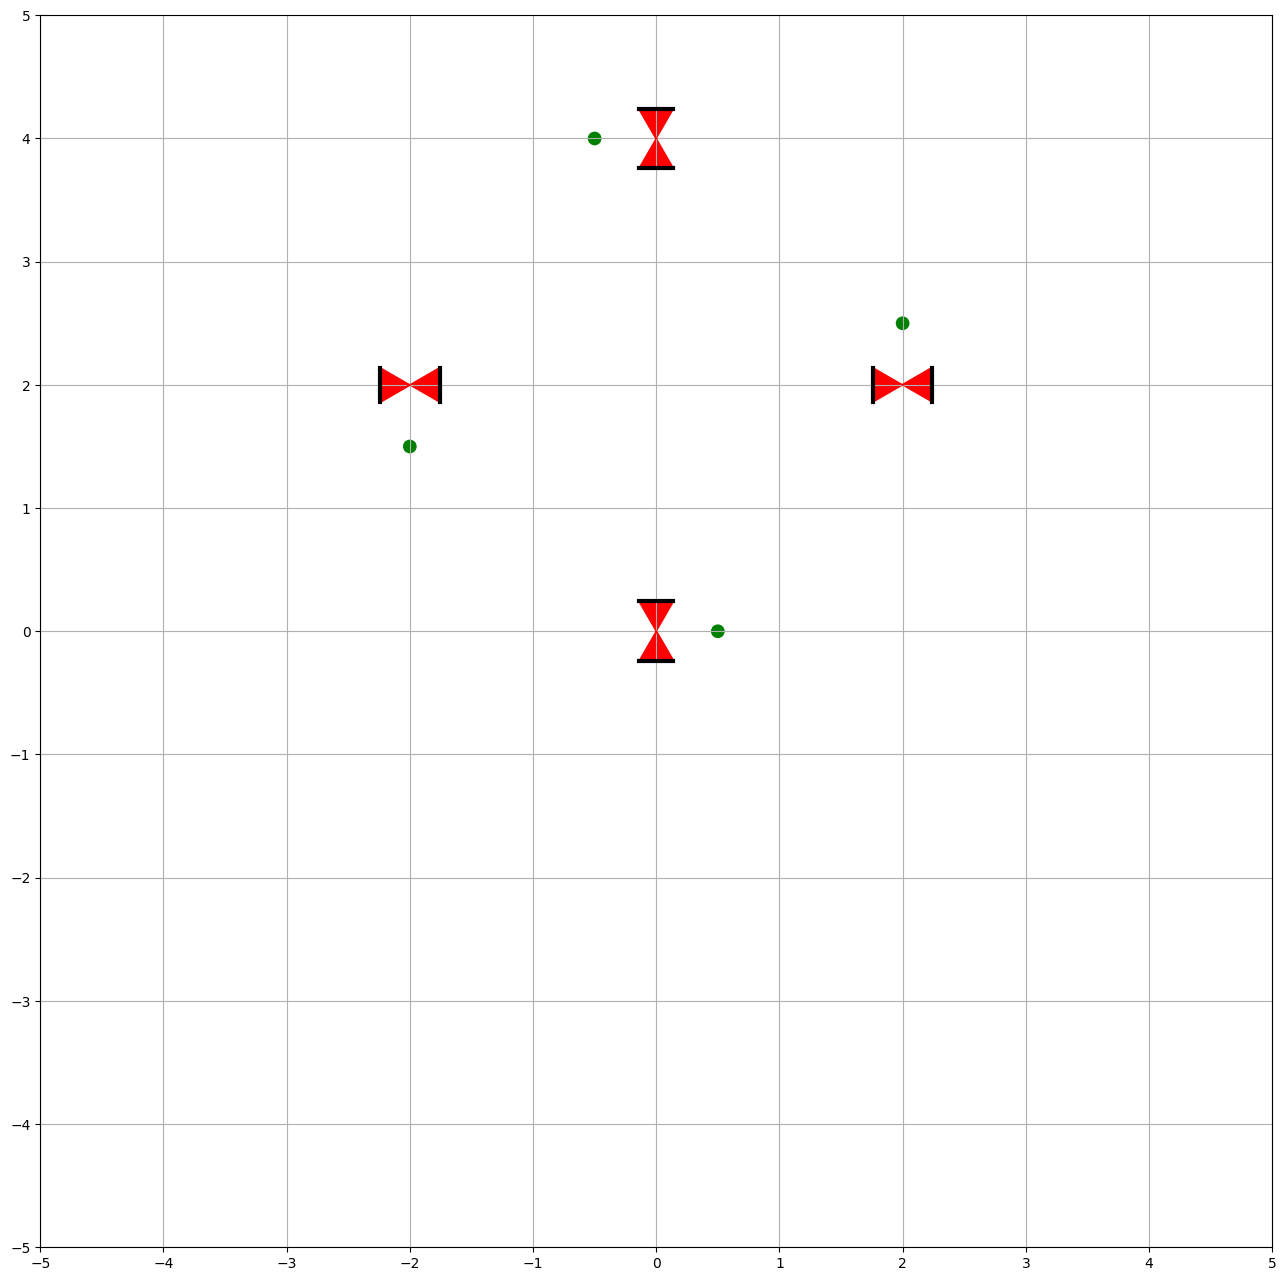

In [7]:
draw_arena(-5, 5, -5, 5)
draw_scooter(0,0,0)
draw_scooter(2,2,pi/2)
draw_scooter(0,4,pi)
draw_scooter(-2,2,3*pi/2)

plt.show

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

Pour établir les équations différentielles reliant $\dot{x}$, $\dot{y}$ et $\dot{\theta}$ à $\omega_l$ et $\omega_r$, nous devons d'abord définir les vitesses des roues gauche et droite, puis les relier à la vitesse du scooter dans le plan $(x, y)$ et à sa vitesse angulaire $\dot{\theta}$.

Soient:

- $R$ le rayon des roues,
- $L$ la distance entre les roues (empattement),
- $\ell$ la distance du centre du châssis à l'axe de la roue (la moitié de l'empattement).

La vitesse des roues gauche et droite, $v_l$ et $v_r$ respectivement, peut être exprimée comme suit: \\

$v_l = R \cdot \omega_l
$

$
v_r = R \cdot \omega_r
$

La vitesse du centre du châssis $(\dot{x}, \dot{y})$ peut être obtenue à partir de la moyenne des vitesses des deux roues:

$
\dot{x} = \frac{v_l + v_r}{2} \cdot \cos(\theta)
$

$
\dot{y} = \frac{v_l + v_r}{2} \cdot \sin(\theta)
$

La vitesse angulaire $\dot{\theta}$ peut être exprimée en termes de différence entre les vitesses des roues gauche et droite, divisée par la distance entre les roues:

$
\dot{\theta} = \frac{v_r - v_l}{L}
$

En substituant $v_l$ et $v_r$ par leurs expressions en termes de $\omega_l$ et $\omega_r$, on obtient:

$
\dot{\theta} = \frac{R}{L} (\omega_r - \omega_l)
$

Maintenant, nous avons un ensemble d'équations différentielles reliant $\dot{x}$, $\dot{y}$ et $\dot{\theta}$ à $\omega_l$ et $\omega_r$:

$
\dot{x} = \frac{R}{2} (\omega_l + \omega_r) \cos(\theta)
\\ $ \\
$ \dot{y} = \frac{R}{2} (\omega_l + \omega_r) \sin(\theta)
 \\ $

$
\dot{\theta} = \frac{R}{L} (\omega_r - \omega_l)
$



### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

On sait que $\omega_{p} et \omega_{r}$ sont des fonctions continument différentieables en fonction de $h$ , $y$ et $θ  \\ $
* On a donc : \\ $ \omega_{l}=G_{l} ( x \cdot y \cdot \theta) \\ $  
$ \omega_{r}=G_{r} ( x \cdot y \cdot \theta) \\ $  
Et on a donc :
$ \begin{pmatrix}
\dot{x}  \\
\dot{y}  \\
\dot{\theta}
\end{pmatrix} = \begin{pmatrix}
\dfrac{1}{2}r(\frac{R}{2} (\omega_l + \omega_r) \cos(\theta)  \\
\frac{R}{2} (\omega_l + \omega_r) \sin(\theta)  \\
\frac{R}{L} (\omega_r - \omega_l)
\end{pmatrix} $
\\
* On considère alors la fonction: \\
$f$: $\mathbb{R}^3$ ⟶ $\mathbb{R}^3$ \\
$ \begin{pmatrix}
{x}  \\
{y}  \\
{\theta}
\end{pmatrix} ⟶ \begin{pmatrix}
\dfrac{1}{2}r(\frac{R}{2} (G_l + G_r) \cos(\theta)  \\
\frac{R}{2} (G_l + G_r) \sin(\theta)  \\
\frac{R}{L} (G_r - G_l)
\end{pmatrix} $ \\
$G_l(x, y , \theta), G_r(x, y , \theta)$

* On a f est continue, ce qui assure l'existence de la solution.
* La matrice Jacobienne de f, $\frac{\partial f}{\partial x} $ existe et continue car $\omega_r$ et $\omega_l$  sont continument différentiables, e qui assure l'unicité de la solution maximale.
* D'après ce qui précède, on en déduit que le système est bien posé.


🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**TODO**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [14]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [15]:
def fun(t, xytheta):

    x, y ,theta = xytheta
    w=omega(t,xytheta)

    xp = 1/2 * r * (w[0] + w[1]) *cos(theta)
    yp = 1/2 * r * (w[0] + w[1]) *sin(theta)
    theta_p = r/l * (w[1] - w[0])

    return array([xp , yp ,theta_p])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [16]:
t_span = [0.0, 4]
y0 = [0.0, 0.0, 0.0]
max_step=0.01
t_eval = linspace(0,4,9)
result = solve_ivp(fun=fun, t_span=t_span, y0=y0,  max_step=max_step, t_eval=t_eval)
r_t = result["t"]
x = result["y"][0]
y = result["y"][1]
theta = result["y"][2]
sol=result["sol"]

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

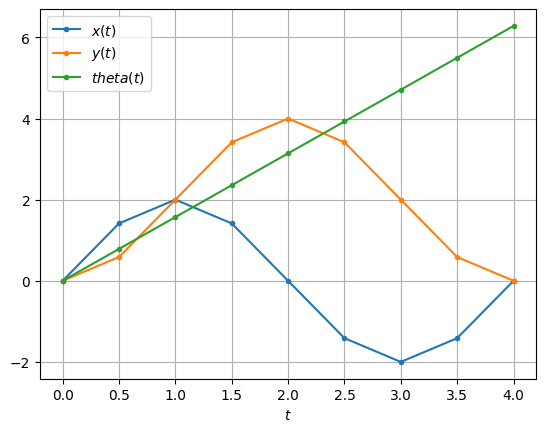

In [17]:
figure()
plot(r_t ,x, ".-", label="$x(t)$")
plot(r_t, y, ".-", label="$y(t)$")
plot(r_t, theta, ".-", label="$theta(t)$")
xlabel("$t$"); grid(); legend()

🧩 Use the simulation results to display the robot location every 0.5 second.

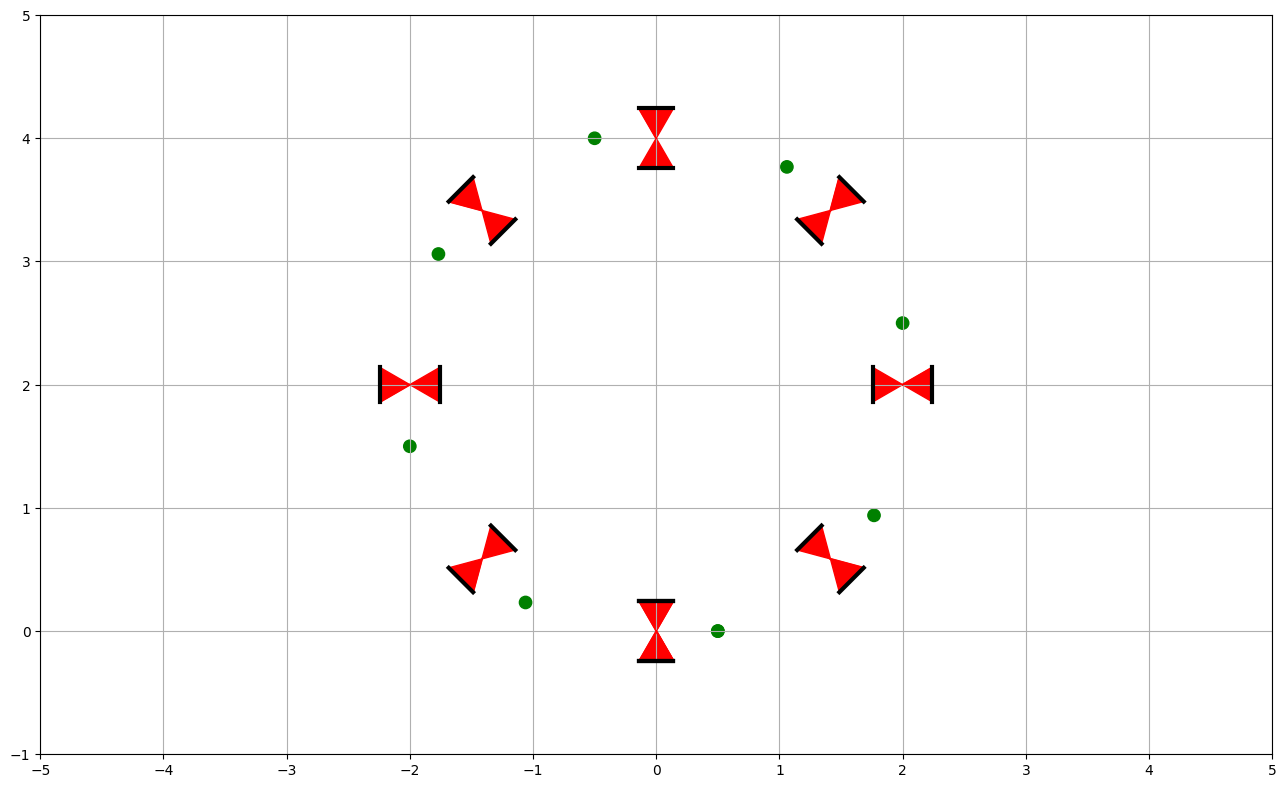

In [18]:
draw_arena(-5, 5, -1, 5)
for i in range(len(x)):
    draw_scooter(x[i],y[i],theta[i])


🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?

$\theta(t) = \left(\frac{\pi}{2}\right) t \\
x(t) = 2 \sin\left(\frac{\pi}{2} t\right) \\
y(t) = -2 \cos\left(\frac{\pi}{2} t\right) + 2 $

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

In [20]:
def resul_theo_0_x_y(t):
    return ( np.pi/2 *t , 2*np.sin(2*np.pi) , 2 - 2* np.cos(np.pi/2 *t) )

t_eval = linspace(0,4,500)
theta_the , x_theo , y_theo =resul_theo_0_x_y(t)

er_x

figure()
plot(r_t ,x - , ".-", label="$x(t)$")
plot(r_t, y, ".-", label="$y(t)$")
plot(r_t, theta, ".-", label="$theta(t)$")
xlabel("$t$"); grid(); legend()

SyntaxError: invalid syntax (<ipython-input-20-0d980c03c3d6>, line 10)

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.

In [ ]:
pass